In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from datetime import datetime

%matplotlib inline

# GitHub Users Analysis

In [61]:
categories = {
    'watch': ['WatchEvent'],
    'interact': ['CommitCommentEvent', 'GollumEvent', 'PullRequestReviewCommentEvent','IssuesEvent', 
                 'IssueCommentEvent'], #'ForkEvent'],
    'contribute': ['CreateEvent', 'DeleteEvent', 'PullRequestEvent', 'PushEvent','ReleaseEvent', 'MemberEvent'],
    'fork': ['ForkEvent']
}

cat_list = ['contribute','interact','watch']
cat_list_2 = cat_list + ['fork']

def define_category(event):
    for c in categories.keys():
        if event in categories[c]:
            return c

def get_perc_distr(row, clist):
    sum_a = sum([row[c] for c in clist])
    
    norm_row = {}
    for c in clist:
        norm_row[c] = float(row[c])/sum_a
        
    return pd.Series(norm_row)

In [3]:
path = './'

# Users behavior

Analysis of users and how they interact inside target projects based on historical data of GitHub activities in **2015** and **2016**.

In [4]:
# data import
a18 = pd.read_csv(path + 'target_a_2018.csv', parse_dates=['created_at'])

In [5]:
a18.head()

,source,target,event,created_at
0,34407843,94911145,WatchEvent,2018-01-09 03:00:00+00:00
1,20942571,103645588,PushEvent,2018-01-09 03:00:08+00:00
2,30802089,101394335,IssueCommentEvent,2018-01-09 03:00:23+00:00
3,34146419,88111990,ForkEvent,2018-01-09 03:00:28+00:00
4,1789,113402414,WatchEvent,2018-01-09 03:00:32+00:00


In [6]:
a18['event'].unique()

array(['WatchEvent', 'PushEvent', 'IssueCommentEvent', 'ForkEvent',
       'IssuesEvent', 'PullRequestReviewCommentEvent', 'PullRequestEvent',
       'CommitCommentEvent', 'CreateEvent', 'DeleteEvent', 'ReleaseEvent',
       'MemberEvent', 'GollumEvent', 'PublicEvent'], dtype=object)

In [7]:
# basic statistics
print('#activities: {}'.format(a18.shape[0])) 
print('#users: {}'.format(len(a18['source'].unique())))

#activities: 2747941
#users: 709532


In [8]:
a18['cat'] = a18['event'].apply(lambda x: define_category(x))

In [9]:
a18['cat'].value_counts()

watch         1481861
interact       678013
contribute     323454
fork           264597
Name: cat, dtype: int64

## Activities Distribution

In [10]:
cat = a18.groupby(by=['target', 'cat'])[['source']].count().reset_index()
cat.columns = ['project', 'category', '#events']

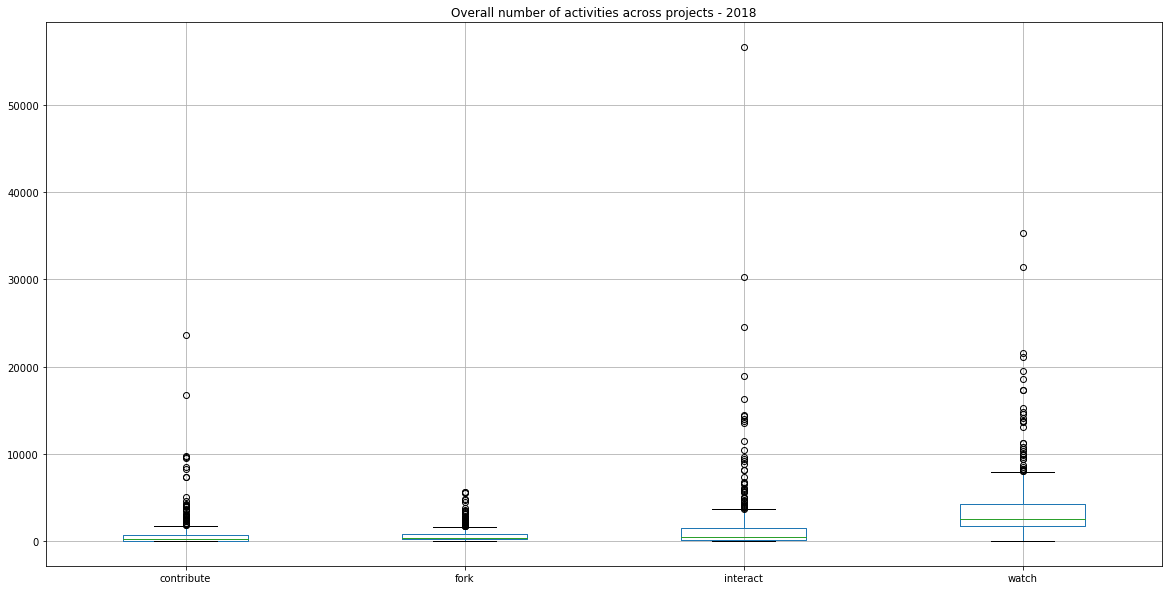

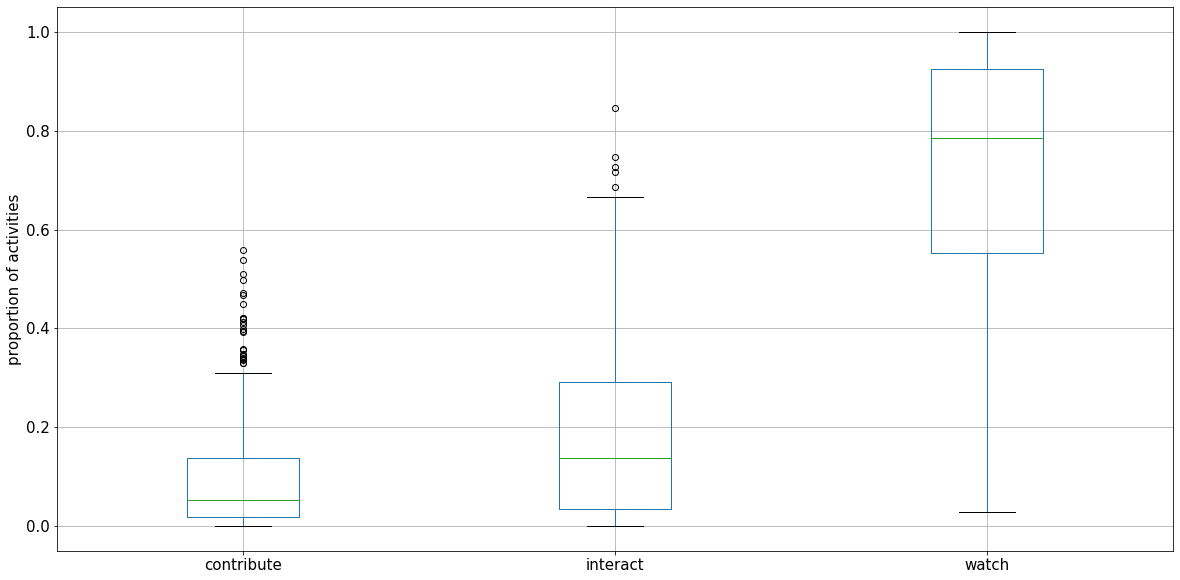

In [12]:
distr = cat.pivot(index='project', columns='category', values='#events').fillna(0)
distr.boxplot(figsize=(20,10))
plt.title('Overall number of activities across projects - 2018')

plt.figure(2, figsize=(20,10))
distr.apply(lambda x: get_perc_distr(x, cat_list), axis=1).boxplot()
#plt.title('Percentage of activities in each category - 2016')
font = 15
plt.ylabel('proportion of activities', fontsize=font)
plt.xticks(fontsize=font);
plt.yticks(fontsize=font);

In [13]:
distr.apply(lambda x: get_perc_distr(x, cat_list), axis=1).describe()

,contribute,interact,watch
count,400.000000,400.000000,400.000000
mean,0.096994,0.185790,0.717216
std,0.109815,0.174197,0.244585
min,0.000000,0.000000,0.028974
25%,0.019244,0.033921,0.552676
50%,0.052220,0.137587,0.785779
75%,0.137259,0.291620,0.925535
max,0.558714,0.845321,1.000000


In [15]:
u_cat = a18.groupby(by=['source', 'cat'])[['target']].count().reset_index()
u_cat.columns = ['user', 'category', '#events']
u_cat.head()

,user,category,#events
0,17,fork,1
1,17,interact,2
2,17,watch,3
3,19,watch,1
4,22,watch,1


In [16]:
u_distr = u_cat.pivot(index='user', columns='category', values='#events').fillna(0)
u_distr.head()

category,contribute,fork,interact,watch
user,,,,
17,0.0,1.0,2.0,3.0
19,0.0,0.0,0.0,1.0
22,0.0,0.0,0.0,1.0
23,0.0,0.0,0.0,1.0
25,0.0,1.0,0.0,3.0


In [17]:
norm_u_distr = u_distr.div(u_distr.sum(axis=1), axis=0)
norm_u_distr.head()

category,contribute,fork,interact,watch
user,,,,
17,0.0,0.166667,0.333333,0.50
19,0.0,0.000000,0.000000,1.00
22,0.0,0.000000,0.000000,1.00
23,0.0,0.000000,0.000000,1.00
25,0.0,0.250000,0.000000,0.75


In [18]:
norm_u_distr.shape

(709524, 4)

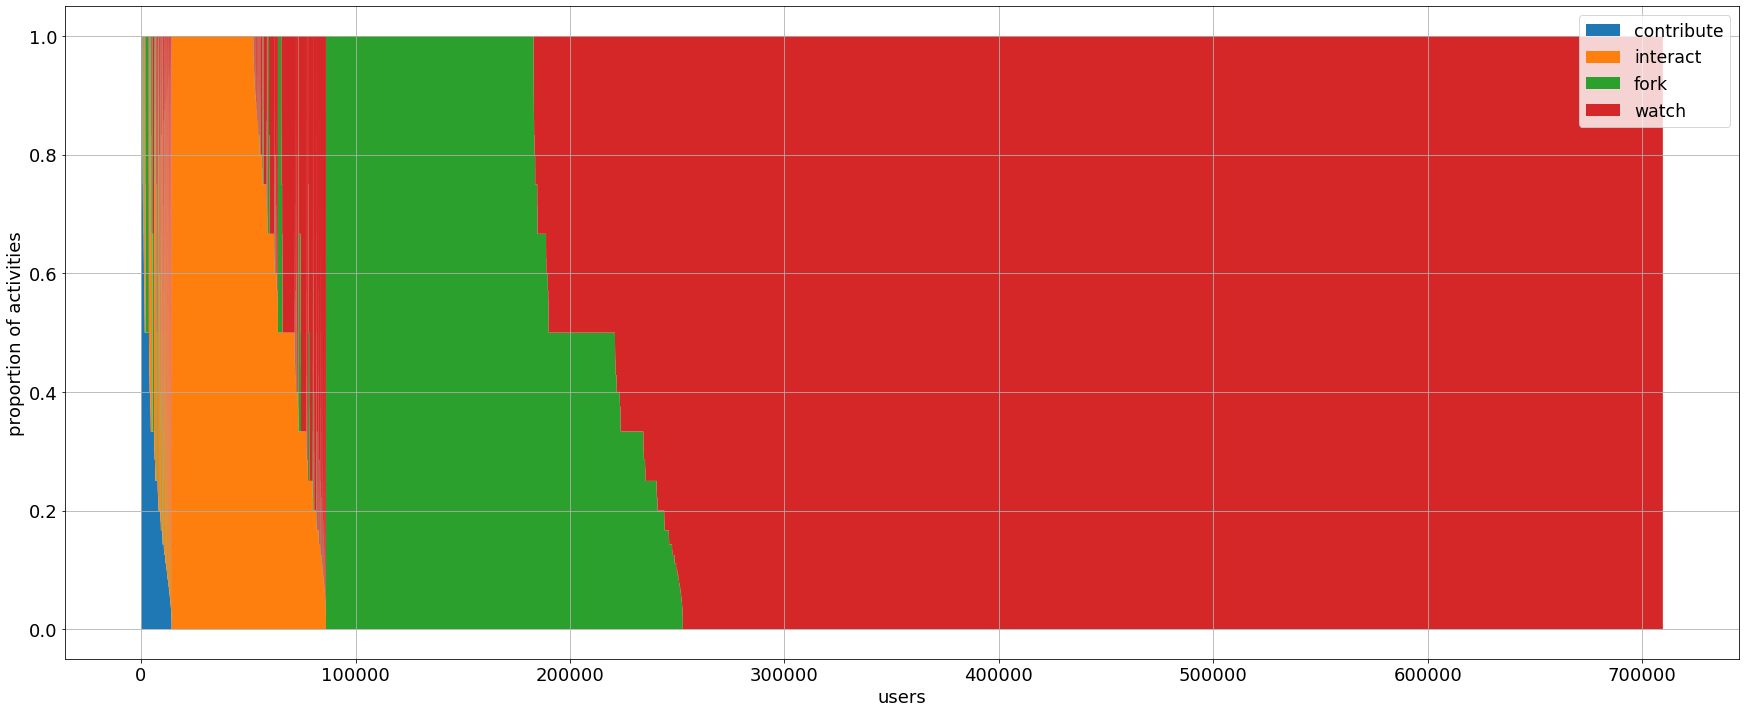

In [19]:
font = 18

plt.figure(figsize=(30, 12))

N = norm_u_distr.shape[0]
x = range(N)
y = norm_u_distr.sample(N).sort_values(by=['contribute', 'interact','fork'], ascending=False)

plt.fill_between(x, 0, y["contribute"], label='contribute')
plt.fill_between(x, y["contribute"], y["interact"]+y["contribute"], label='interact')
plt.fill_between(x, y["contribute"]+y["interact"], y["interact"]+y["contribute"]+y["fork"], label='fork')
plt.fill_between(x, y["interact"] + y['contribute']+y["fork"], y["watch"]+y["interact"]+y['contribute']+y["fork"], 
                                                                                         label='watch')
plt.grid()
plt.legend(fontsize='xx-large')
plt.xlabel('users', fontsize=font)
plt.ylabel('proportion of activities', fontsize=font)
plt.xticks(fontsize=font);
plt.yticks(fontsize=font);

In [20]:
N_contrib = norm_u_distr[norm_u_distr['contribute'] > 0].shape[0]
print(N_contrib, float(N_contrib)/N)

14261 0.020099390577344813


In [21]:
N_interact = norm_u_distr[(norm_u_distr['contribute'] == 0) & (norm_u_distr['interact'] > 0)].shape[0]
print(N_interact, float(N_interact)/N)

71961 0.10142151639690836


In [22]:
N_fork = norm_u_distr[(norm_u_distr['contribute'] == 0) & 
                      (norm_u_distr['interact'] == 0) & 
                      (norm_u_distr['fork'] > 0)].shape[0]
print(N_fork, float(N_fork)/N)

166380 0.2344952390616808


In [23]:
N_fork_only = norm_u_distr[(norm_u_distr['contribute'] == 0) & 
                      (norm_u_distr['interact'] == 0) & 
                      (norm_u_distr['fork'] > 0) &
                      (norm_u_distr['watch'] == 0)].shape[0]
print(N_fork_only, float(N_fork_only)/N)

96814 0.136449225114302


In [24]:
N_watch = norm_u_distr[(norm_u_distr['contribute'] == 0) & 
                      (norm_u_distr['interact'] == 0) & 
                      (norm_u_distr['fork'] == 0) &
                      (norm_u_distr['watch'] > 0)].shape[0]
print(N_watch, float(N_watch)/N)

456922 0.6439838539640661


In [25]:
N_w_f = norm_u_distr[(norm_u_distr['contribute'] == 0) & 
                      (norm_u_distr['interact'] == 0) & 
                      (norm_u_distr['fork'] > 0) &
                      (norm_u_distr['watch'] > 0)].shape[0]
print(N_w_f, float(N_w_f)/N) 

69566 0.0980460139473788


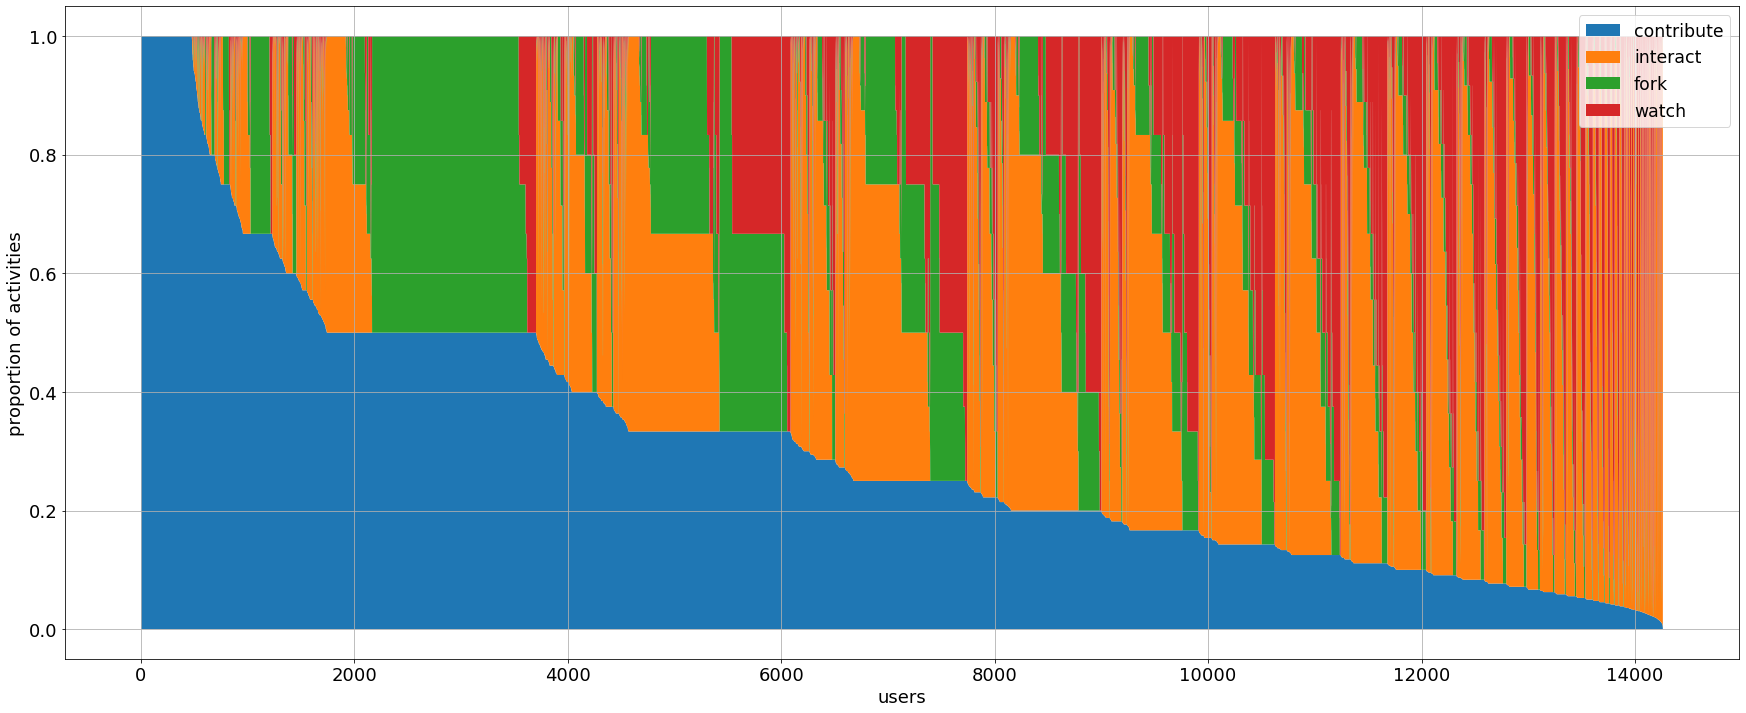

In [26]:
font = 18

plt.figure(figsize=(30, 12))


y = norm_u_distr[norm_u_distr['contribute']>0].sort_values(by=['contribute','interact','fork'], ascending=False)
x = range(y.shape[0])

plt.fill_between(x, 0, y["contribute"], label='contribute')
plt.fill_between(x, y["contribute"], y["interact"]+y["contribute"], label='interact')
plt.fill_between(x, y["contribute"]+y["interact"], y["interact"]+y["contribute"]+y["fork"], label='fork')
plt.fill_between(x, y["interact"] + y['contribute']+y["fork"], y["watch"]+y["interact"]+y['contribute']+y["fork"], 
                                                                                         label='watch')
plt.grid()
plt.legend(fontsize='xx-large')
plt.xlabel('users', fontsize=font)
plt.ylabel('proportion of activities', fontsize=font)
plt.xticks(fontsize=font);
plt.yticks(fontsize=font);

## Activities distribution month by month

In [38]:
import pytz

In [46]:
start_d = datetime(2018, 1, 1, tzinfo=pytz.timezone('UTC'))
next_d = start_d + pd.DateOffset(months=1)

cat_distr = {'contribute': [], 'interact': [], 'watch': [], 'fork': []}
for _ in range(12):
    
    curr_a = a18[(a18['created_at'] >= start_d) & (a18['created_at'] < next_d)]

    cat = curr_a.groupby(by=['target', 'cat'])[['source']].count().reset_index()
    cat.columns = ['project', 'category', '#events']

    
    distr = cat.pivot(index='project', columns='category', values='#events').fillna(0)
    norm_distr = distr.apply(lambda x: get_perc_distr(x, cat_list_2), axis=1)
    for c in cat_list_2:
        cat_distr[c].append(norm_distr[c].values)
    
    start_d = next_d
    next_d = start_d + pd.DateOffset(months=1)

In [40]:
base = start_d
date_list = [base + pd.DateOffset(months=x) for x in range(0, 12)]
date_labels = [x.strftime('%b %Y') for x in date_list]

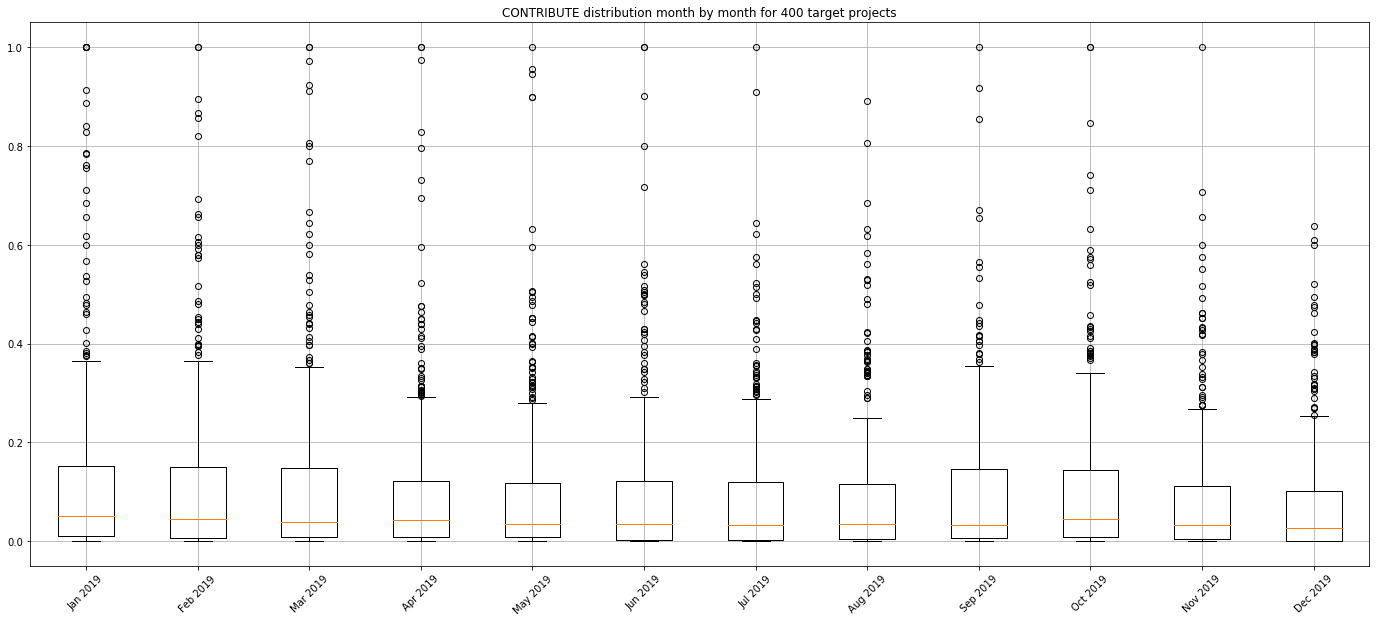

In [47]:
plt.figure(figsize=(24, 10))
plt.boxplot(cat_distr['contribute'])
plt.xticks(range(1, 13), date_labels, rotation=45)
plt.title('CONTRIBUTE distribution month by month for 400 target projects')
plt.grid()

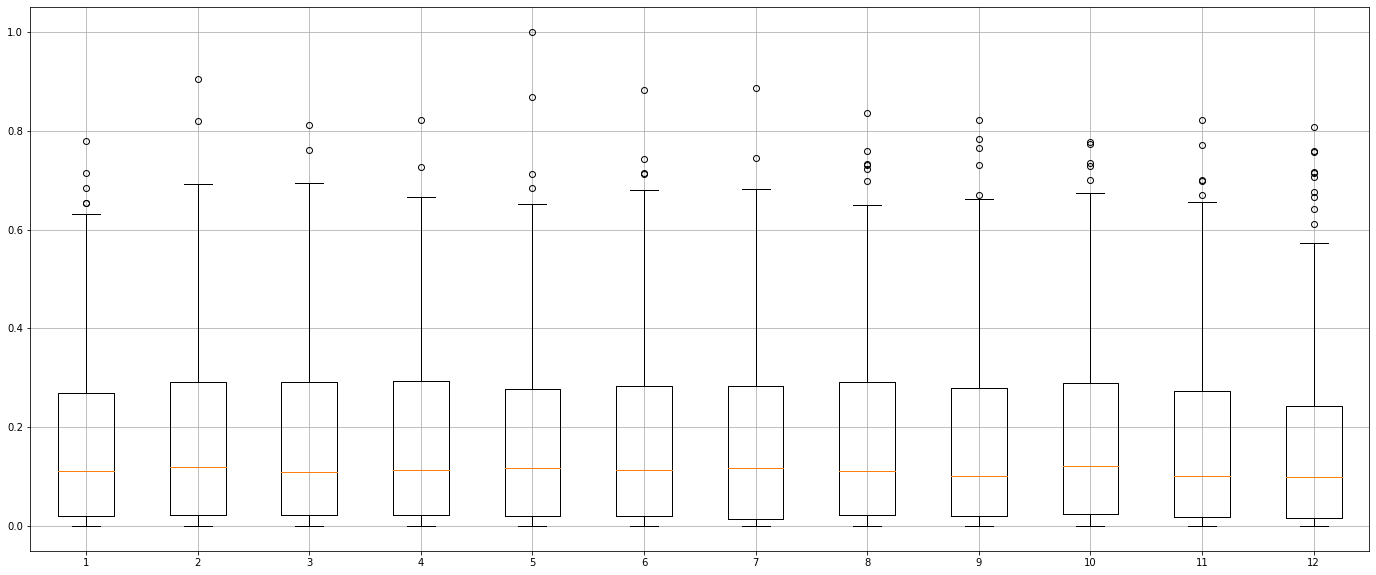

In [48]:
plt.figure(figsize=(24, 10))
plt.boxplot(cat_distr['interact'])
plt.grid()

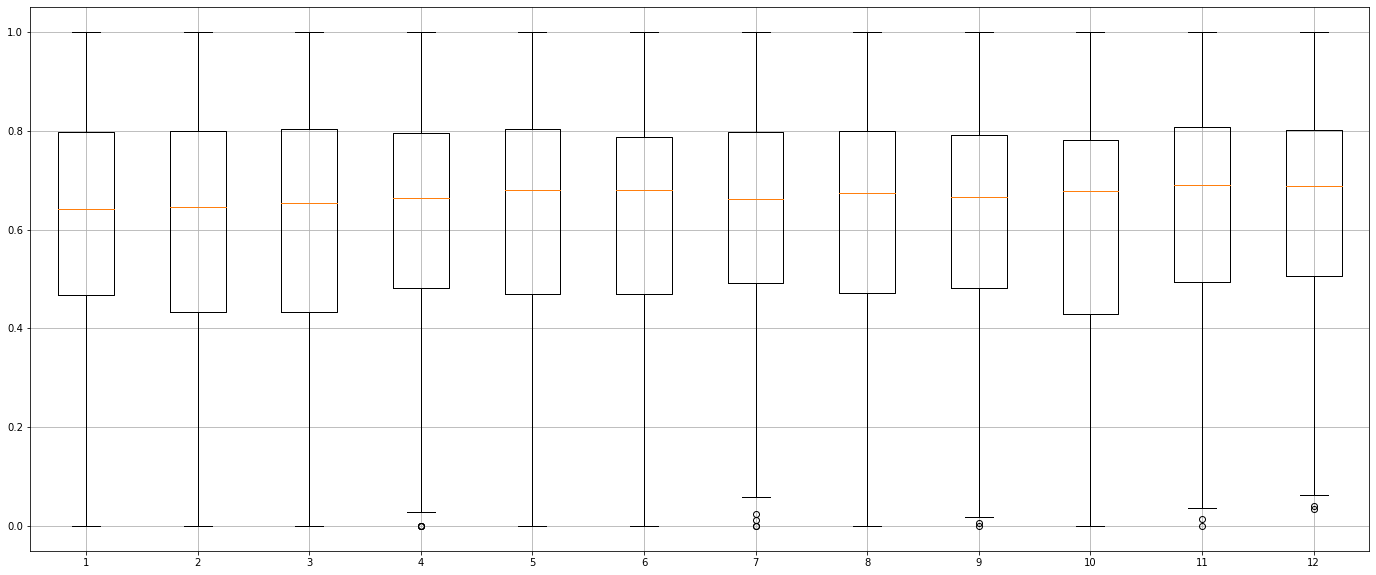

In [49]:
plt.figure(figsize=(24, 10))
plt.boxplot(cat_distr['watch'])
plt.grid()

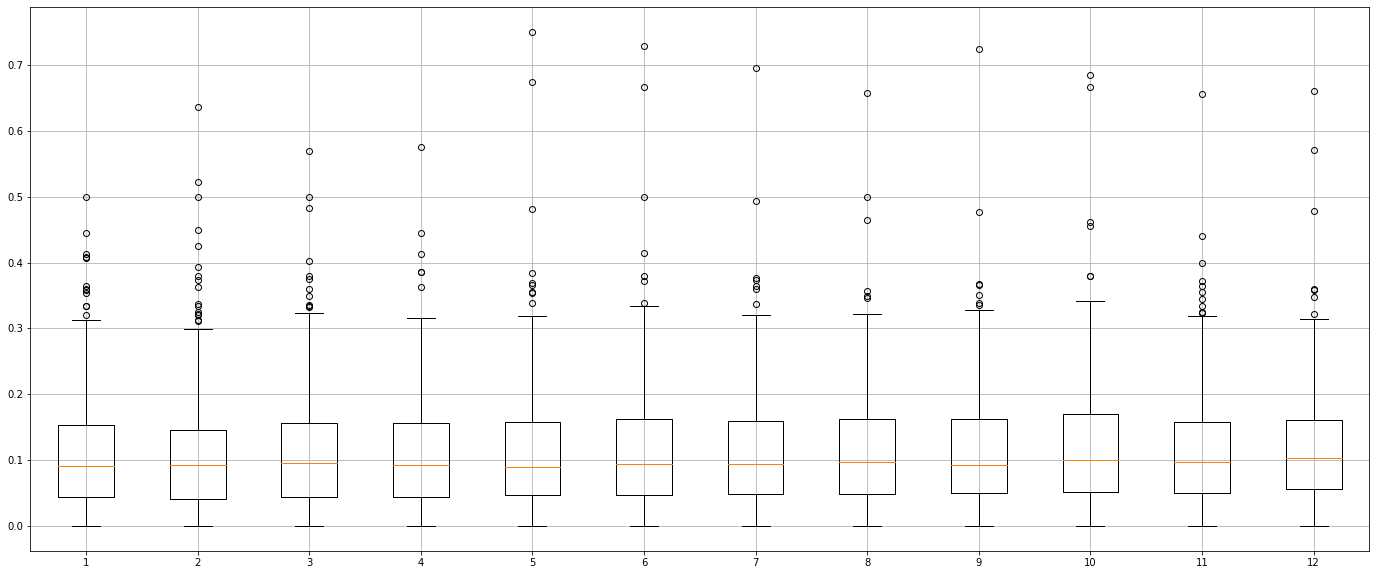

In [51]:
plt.figure(figsize=(24, 10))
plt.boxplot(cat_distr['fork'])
plt.grid()

## Activities Distribution inside projects

In [53]:
counts = a18.groupby(by=['target', 'cat'])[['source']].count().reset_index()
counts.columns = ['project', 'category', '#events']
counts.head()

,project,category,#events
0,77912349,contribute,202
1,77912349,fork,662
2,77912349,interact,60
3,77912349,watch,2000
4,77993578,contribute,106


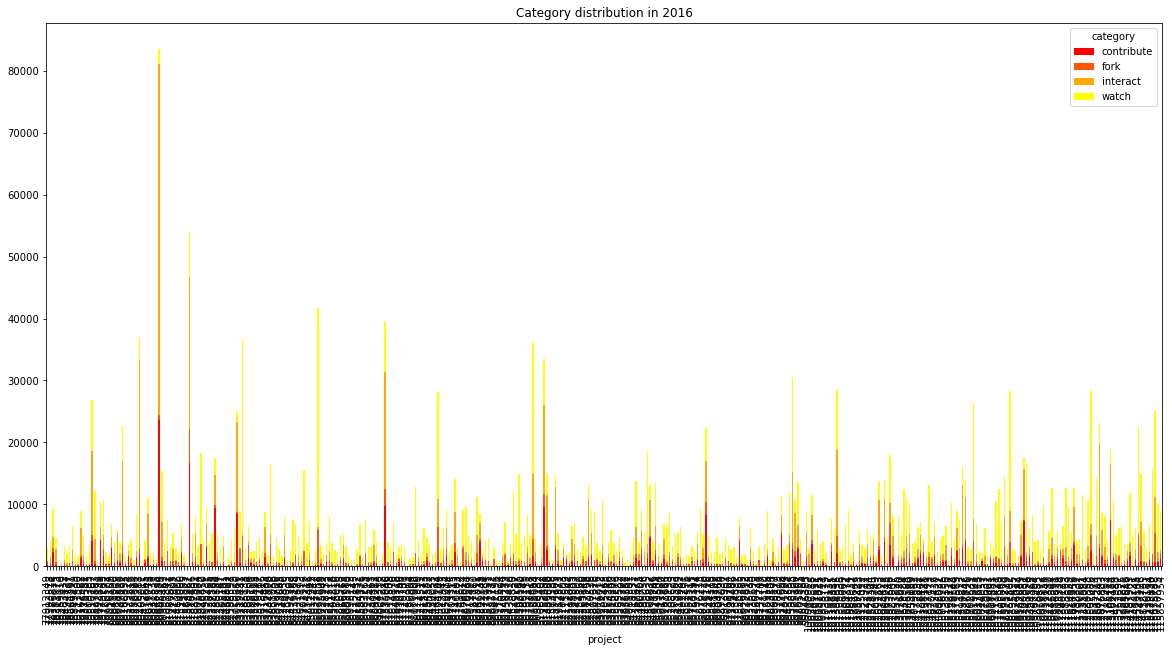

In [54]:
cmap = cm.get_cmap('autumn')
counts.pivot(index='project', columns='category', values='#events').fillna(0)\
                                .plot(kind='bar', stacked=True, 
                                      figsize=(20,10), title='Category distribution in 2018', cmap=cmap)

In [56]:
activity_counts = a18.groupby(by=['target', 'event'])[['source']].count().reset_index()
activity_counts.columns = ['project', 'event', 'freq']
activity_counts.head()

,project,event,freq
0,77912349,ForkEvent,662
1,77912349,IssueCommentEvent,33
2,77912349,IssuesEvent,27
3,77912349,PullRequestEvent,5
4,77912349,PushEvent,197


In [57]:
sort_events = ['CreateEvent', 'DeleteEvent', 'PullRequestEvent', 'PushEvent','ReleaseEvent', 'MemberEvent',
              'CommitCommentEvent', 'GollumEvent', 'PullRequestReviewCommentEvent','IssuesEvent', 
               'IssueCommentEvent',
                'ForkEvent', 'WatchEvent']

In [58]:
stacked_activity = activity_counts.pivot(index='project', columns='event', values='freq').fillna(0)
stacked_activity = stacked_activity[sort_events]

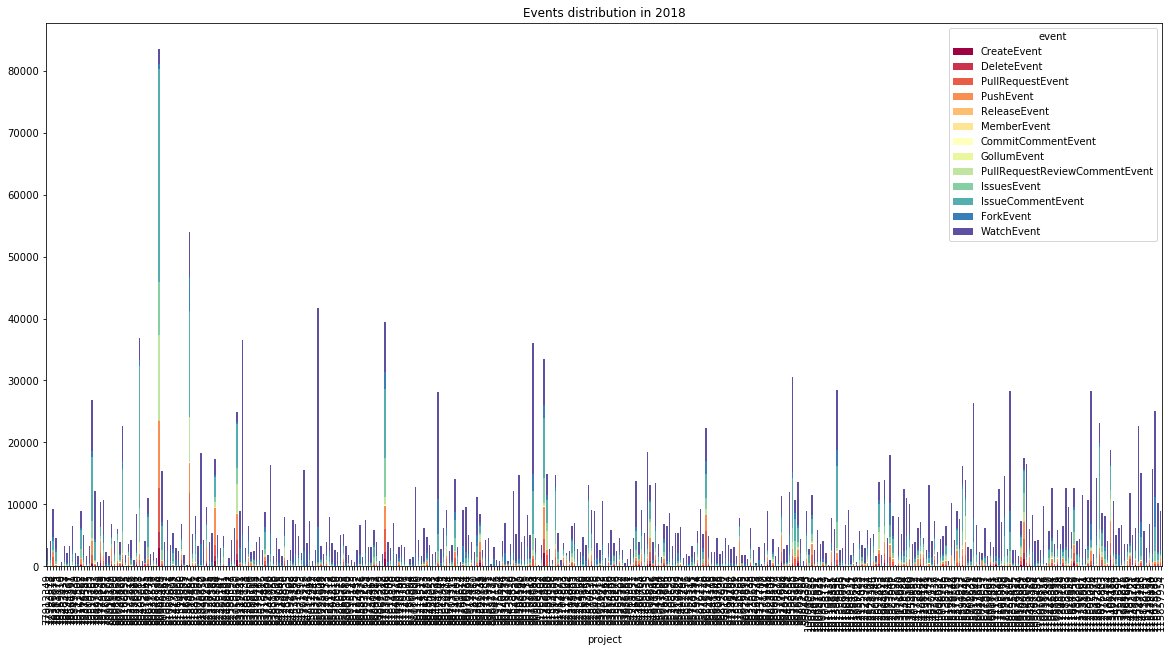

In [59]:
cmap = cm.get_cmap('Spectral')
stacked_activity.plot(kind='bar', stacked=True, figsize=(20,10), title='Events distribution in 2018', cmap=cmap)

In [62]:
elist = []

for e in categories.values():
    elist  = elist + e

In [63]:
stacked_activity_norm = activity_counts.pivot(index='project', columns='event', values='freq').fillna(0)\
        .apply(lambda x: get_perc_distr(x, elist), axis=1)

# sort columns
stacked_activity_norm = stacked_activity_norm[sort_events]

In [64]:
# sort projects
stacked_activity_norm = stacked_activity_norm.sort_values(by=['WatchEvent'])

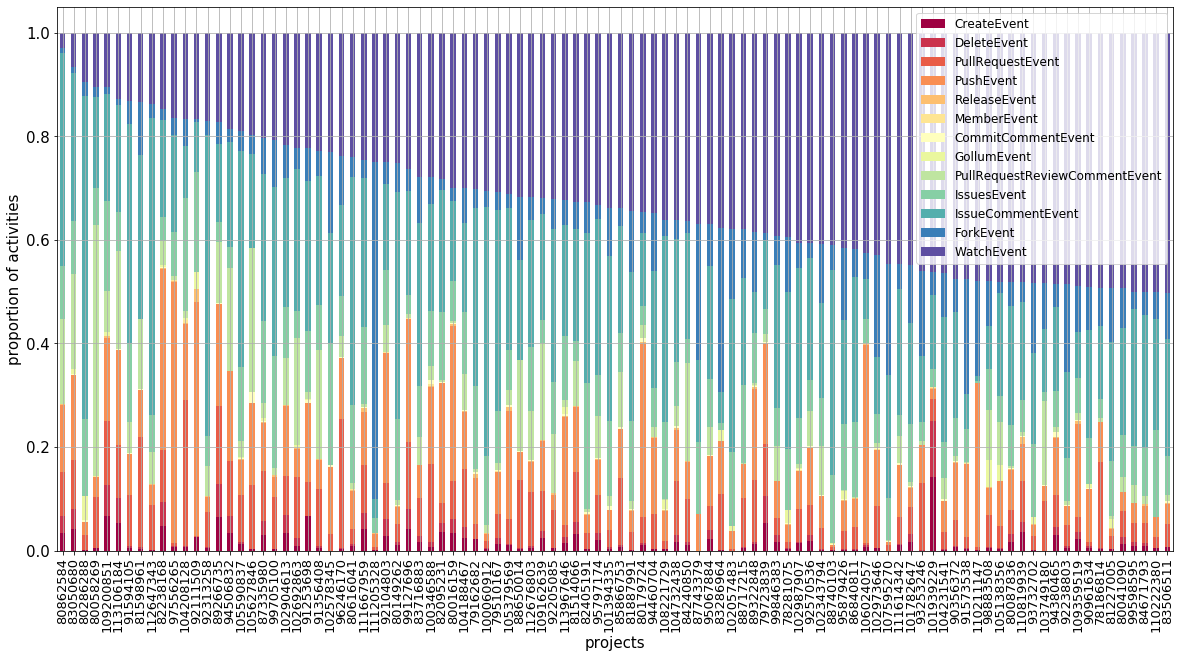

In [67]:
stacked_activity_norm.iloc[:100].plot(kind='bar', stacked=True, figsize=(20,10), cmap=cmap)

font = 15
plt.grid()
plt.legend(fontsize='large')
plt.xlabel('projects', fontsize=font)
plt.ylabel('proportion of activities', fontsize=font)
plt.xticks(fontsize=font-2);
plt.yticks(fontsize=font);

In [71]:
elist

['WatchEvent',
 'CommitCommentEvent',
 'GollumEvent',
 'PullRequestReviewCommentEvent',
 'IssuesEvent',
 'IssueCommentEvent',
 'CreateEvent',
 'DeleteEvent',
 'PullRequestEvent',
 'PushEvent',
 'ReleaseEvent',
 'MemberEvent',
 'ForkEvent']

In [72]:
aggregated_activity = activity_counts.pivot(index='project', columns='event', values='freq').fillna(0)\
        .drop('WatchEvent', axis=1).apply(lambda x: get_perc_distr(x, elist[1:]), axis=1)

# sort columns
aggregated_activity = aggregated_activity[sort_events[:-1]]

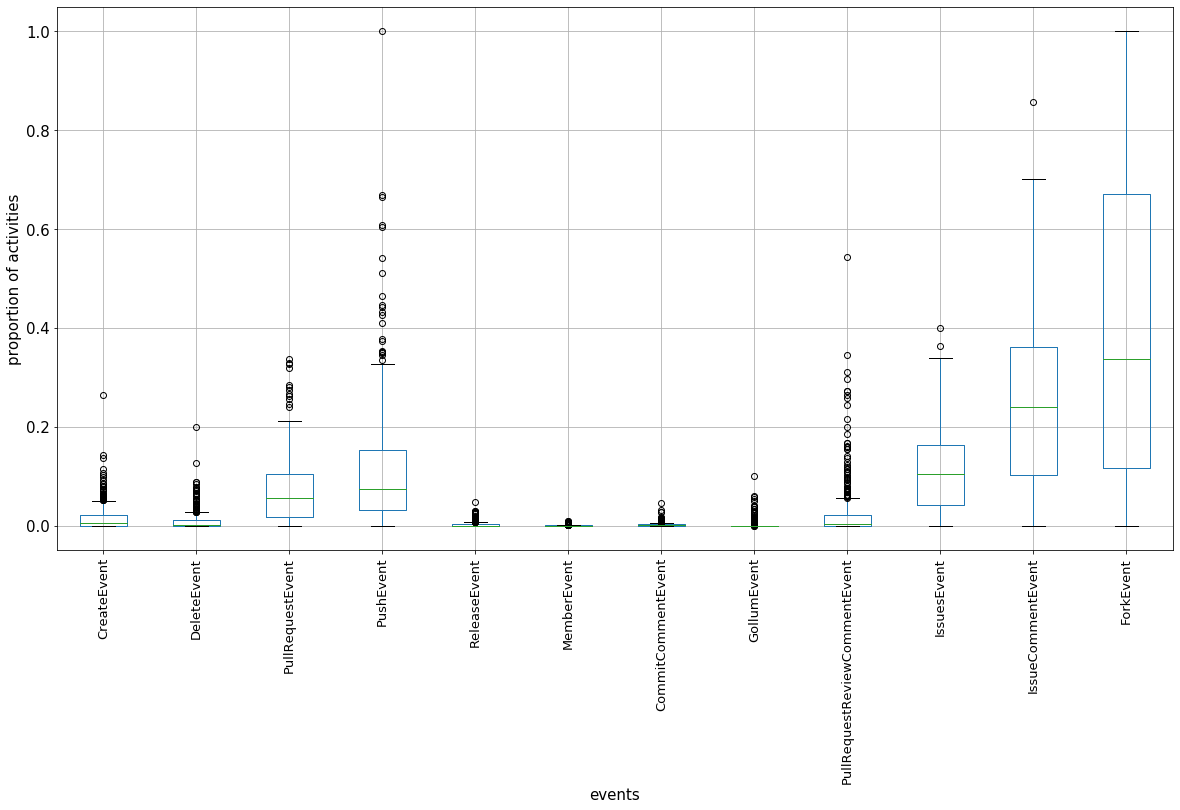

In [73]:
aggregated_activity.boxplot(figsize=(20, 10), rot=90)

font = 15
plt.xlabel('events', fontsize=font)
plt.ylabel('proportion of activities', fontsize=font)
plt.xticks(fontsize=font-2);
plt.yticks(fontsize=font);

In [77]:
p_sample = a18[a18['target'] == 94911145]

In [78]:
p_sample.shape

(13510, 5)

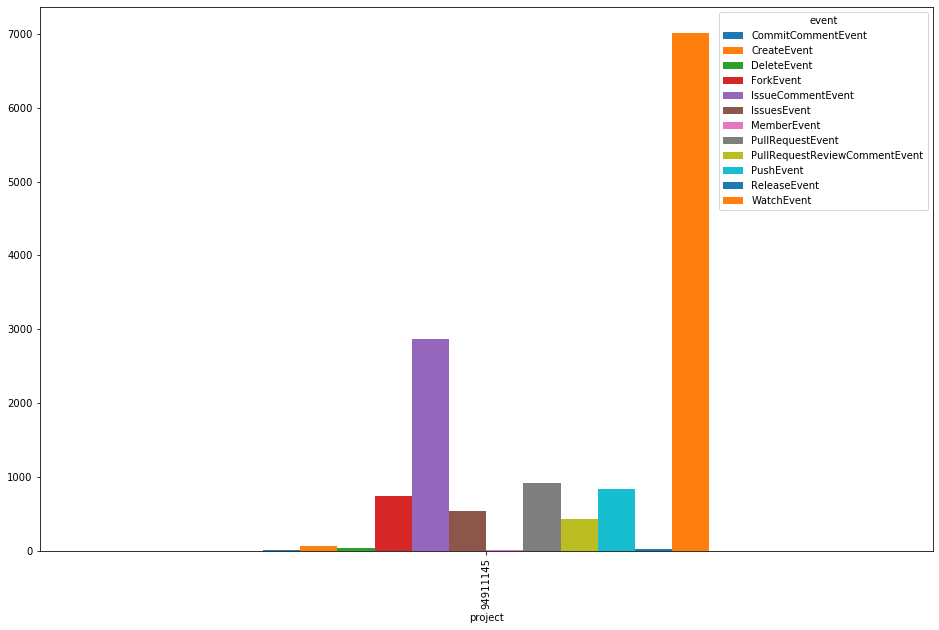

In [79]:
events = p_sample.groupby(by=['target', 'event'])[['source']].count().reset_index()
events.columns = ['project', 'event', '#events']
events.pivot(index='project', columns='event', values='#events').plot(kind='bar', figsize=(16,10))

In [80]:
start_d = datetime(2018, 1, 1, tzinfo=pytz.timezone('UTC'))
next_d = start_d + pd.DateOffset(months=1)

df = pd.DataFrame()
for _ in range(12):
    
    curr_a = p_sample[(p_sample['created_at'] >= start_d) & (p_sample['created_at'] < next_d)]

    events = curr_a.groupby(by=['target', 'event'])[['source']].count().reset_index()
    events.columns = ['project', 'event', '#events']
    row = events.pivot(index='project', columns='event', values='#events')
    row['date'] = start_d.strftime('%b %Y')
    row = row.set_index('date')
    
    df = df.append(row)
    
    start_d = next_d
    next_d = start_d + pd.DateOffset(months=1)

/home/brambilla/anaconda3/envs/oss-p/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


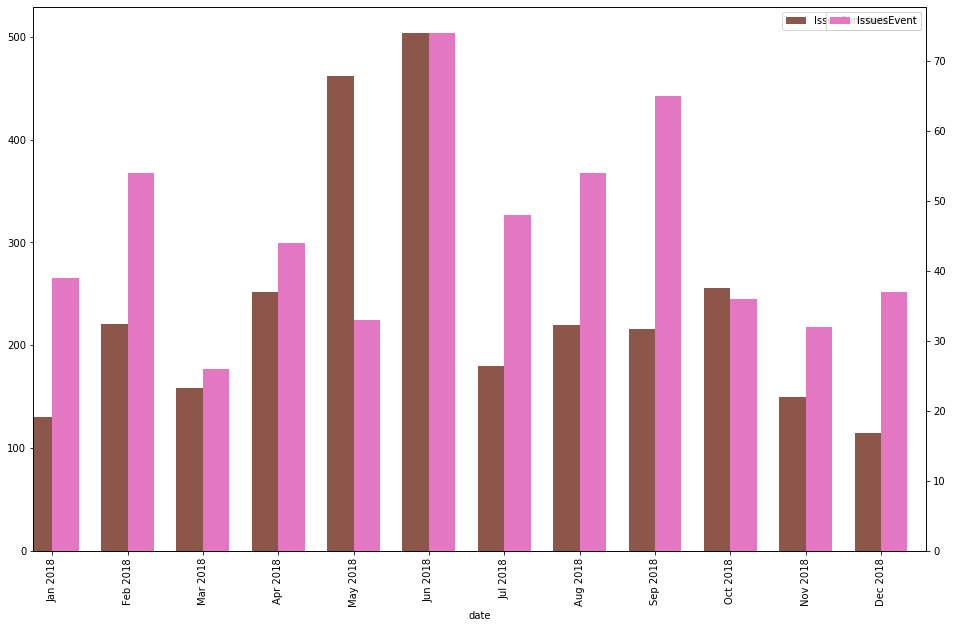

In [81]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
w = 0.35

df[['IssueCommentEvent']].plot(kind='bar', figsize=(16,10), ax=ax1, color='tab:brown', position=1, width=w)
df[['IssuesEvent']].plot(kind='bar', figsize=(16,10), ax=ax2, color='tab:pink', position=0, width=w)

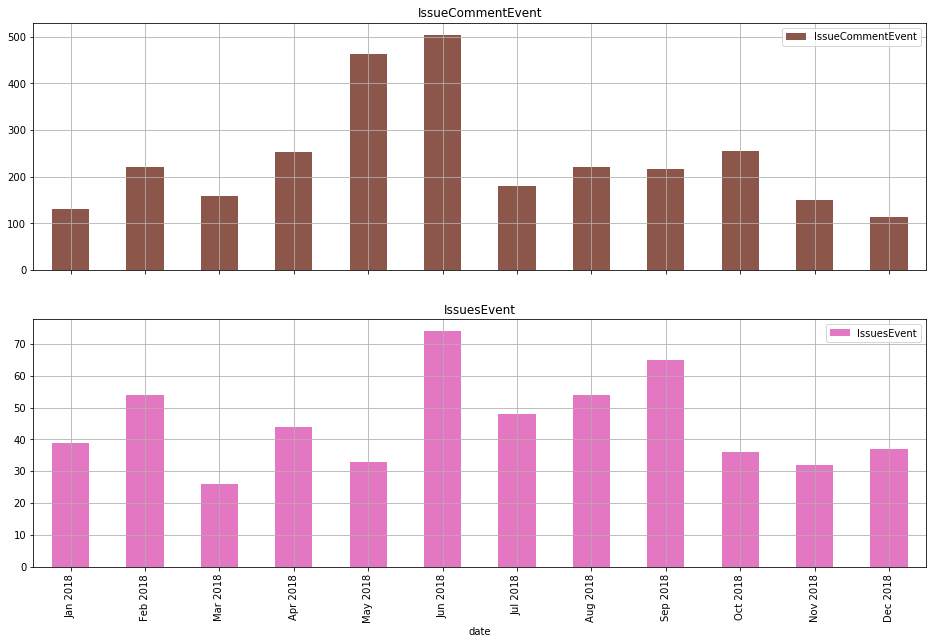

In [82]:
df[['IssueCommentEvent', 'IssuesEvent']].plot(kind='bar', color=['tab:brown', 'tab:pink'],
                                              figsize=(16,10), grid=True,subplots=True,sharex=True);

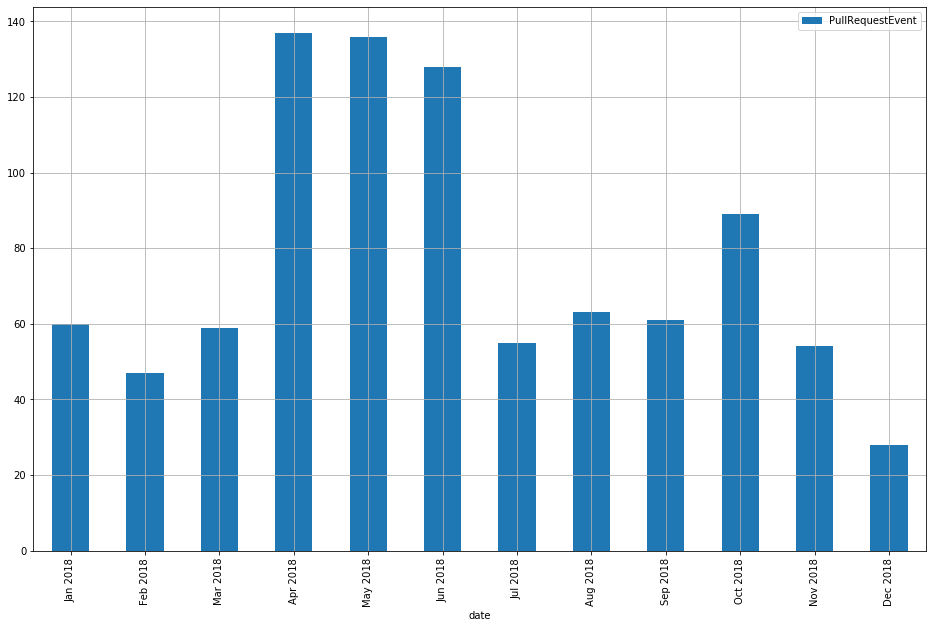

In [83]:
df[[ 'PullRequestEvent']].plot(kind='bar', figsize=(16,10), grid=True);

## Project timeseries

In [85]:
p_ts = p_sample.drop(['source'], axis=1).set_index('created_at')
releases = p_ts[p_ts['event'] == 'ReleaseEvent']

In [86]:
p_ts.head()

,target,event,cat
created_at,,,
2018-01-09 03:00:00+00:00,94911145,WatchEvent,watch
2018-01-09 03:02:38+00:00,94911145,WatchEvent,watch
2018-01-09 03:09:22+00:00,94911145,WatchEvent,watch
2018-01-09 03:10:29+00:00,94911145,WatchEvent,watch
2018-01-09 03:11:08+00:00,94911145,WatchEvent,watch


In [87]:
releases.head()

,target,event,cat
created_at,,,
2018-01-09 21:58:02+00:00,94911145,ReleaseEvent,contribute
2018-02-13 03:32:40+00:00,94911145,ReleaseEvent,contribute
2018-02-17 20:41:50+00:00,94911145,ReleaseEvent,contribute
2018-03-13 16:36:12+00:00,94911145,ReleaseEvent,contribute
2018-03-13 00:03:31+00:00,94911145,ReleaseEvent,contribute


In [88]:
all_ts = pd.DataFrame()
for c in ['contribute', 'interact', 'watch', 'fork']:
    ts = p_ts[p_ts['cat'] == c].groupby(pd.Grouper(freq='D'))[['target']].count()
    ts.columns = [c]
    
    all_ts = pd.concat([all_ts, ts], axis=1)

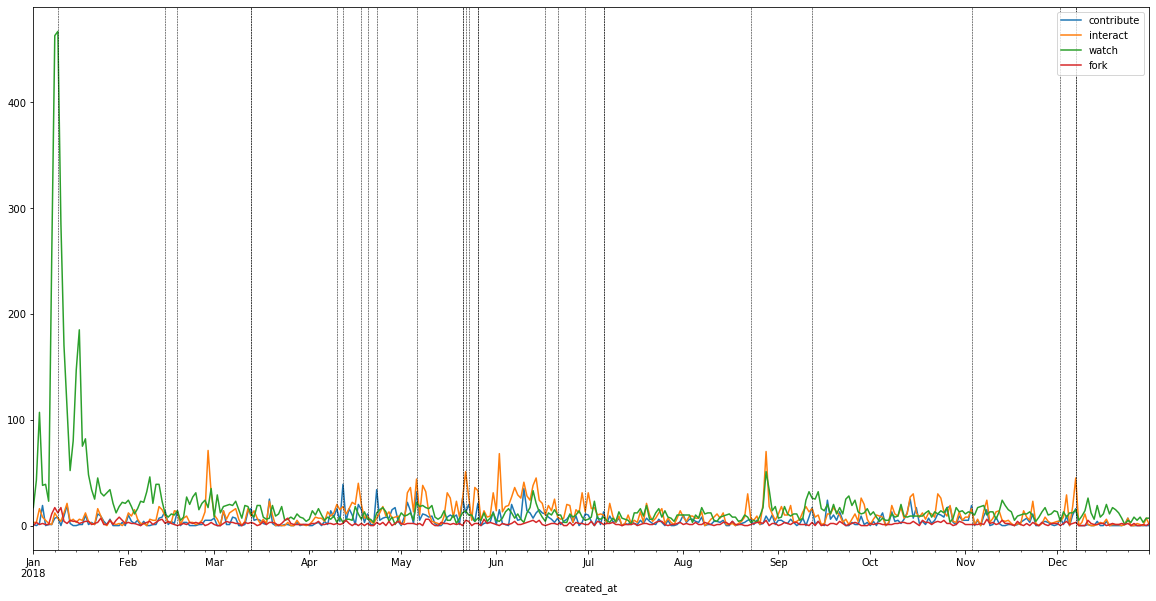

In [92]:
all_ts.fillna(0).plot(figsize=(20, 10))

for r in releases.index:
    plt.axvline(r.date(), linestyle='--', color='black', linewidth=0.5)